In [3]:
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time
from matplotlib import gridspec
from matplotlib import rc


In [4]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [5]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [6]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [7]:
#Check if dengerate
def CheckDegenerate(H):
    estates = H.eigenstates()
    lowState = estates[0][0]
    secLowState = estates[0][1]
    if (abs(lowState-secLowState))<= 1e-10:
        return True
    else:
        return False

In [8]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.groundstate()
        return groundState[0],groundState[1]

In [9]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [10]:
#get randomized RBM parameters (between zero and 1)
def ranRBMpar(N,M):
    par = np.random.rand(2*(N+M+N*M))
    return par

In [11]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm


In [12]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [13]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [14]:
#Gradient Descent
class GradDescent:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M):
        par = ranRBMpar(N,M)
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol = 1e-04, full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)

        return min, found_gs, found_gsEnergy  

In [15]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr


# Histogram N=2, M=1

In [17]:
#Parameter definition 
N= 2
M=3
B = 1
A0 = 1
M1gdResults = [] #gives ground state estimation at each iteration of gd
M1gdState = []
M1gdTime = []

M1edState = []
M1edTime = []

M1ActualEng = []
M1engErr = []
M1stateErr = []

hisIt = np.arange(1)

In [18]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    M1gdResults.append(gd)
    M1gdState.append(gd[0])
    M1gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    M1edState.append(ed[0])
    M1edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    M1ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    M1engErr.append(errTemp[0])
    M1stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -0.957095
         Iterations: 25
         Function evaluations: 1248
         Gradient evaluations: 52


<Figure size 432x288 with 0 Axes>

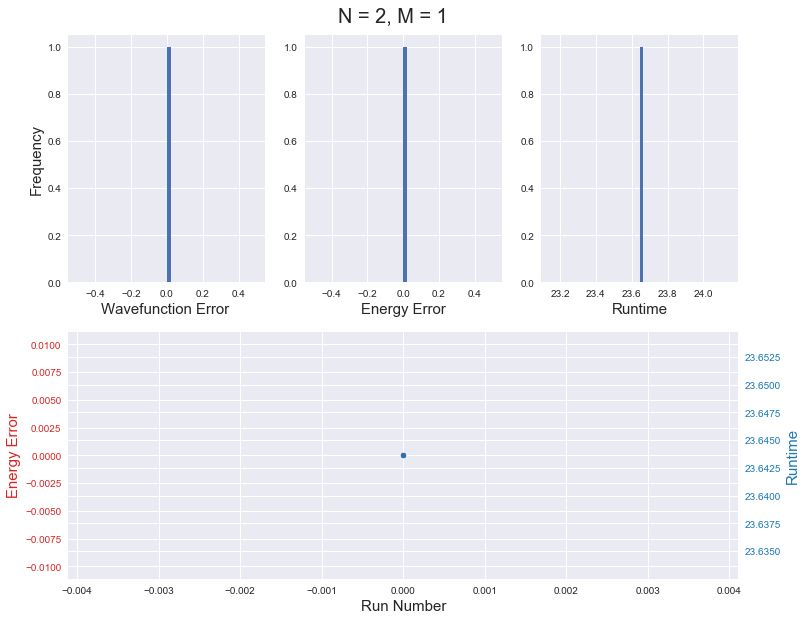

In [22]:

plt.figure(constrained_layout=True)
plt.figure(figsize=(12,10))
ttl = plt.suptitle("N = 2, M = 1",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=2)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(gs[0, 0])
ax1 .hist(M1stateErr, bins=50) 
ax1 .set_xlabel("Wavefunction Error ",size = 15)
ax1 .set_ylabel("Frequency", size = 15)

ax2 = plt.subplot(gs[0, 1])
M1counts, M1bins, M1bars = ax2.hist(M1engErr, bins=50) 
ax2.set_xlabel("Energy Error",size = 15)


ax3 = plt.subplot(gs[0, 2])
ax3.hist(M1gdTime, bins=50) 
ax3.set_xlabel("Runtime",size = 15)



ax4 = plt.subplot(gs[1, :])
color = 'tab:red'
ax4.set_xlabel('Run Number',size = 15)
ax4.set_ylabel('Energy Error', color=color,size = 15)
ax4.scatter(hisIt, M1engErr,color=color, s=25)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax4.twinx()  
color = 'tab:blue'
ax5.set_ylabel('Runtime', color=color,size = 15)  
ax5.scatter(hisIt, M1gdTime, color=color, s=25)
ax5.tick_params(axis='y', labelcolor=color)



In [226]:
print(M1counts)

[79.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 19.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.]


In [221]:
smallError = 0
for i in range(50):
    if M1bins[i]<0.1:
        cutOff=i
print(cutOff)

for i in range(cutOff):
    smallError += M1counts[i]
successPer = smallError
print(successPer)

7
79.0


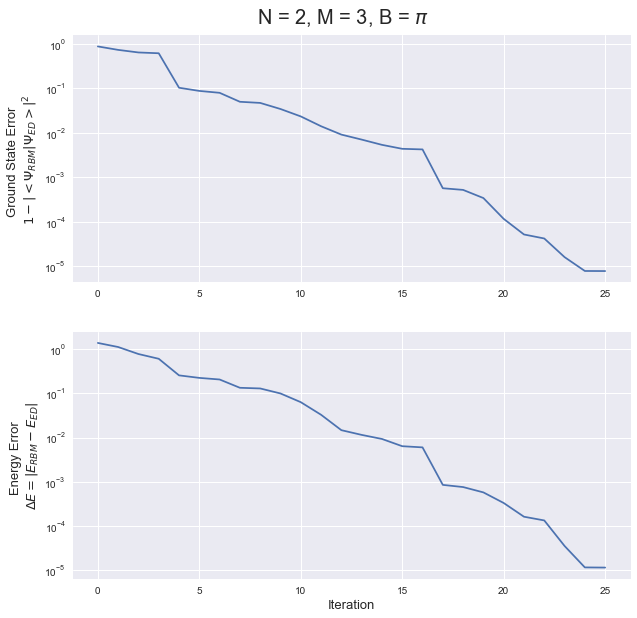

In [42]:
N=2
M=3
parResults =M1gdResults[0][0][0][5]
numIter = len(parResults)
iter = np.arange(numIter)
state = []
eng = []
stateErr = []
engErr = []


gs = M1edState[0][1] 
gsEng = M1ActualEng[0]

#find state at each iteration
for i in range(numIter):
    stateIter = RBM_ansatz(parResults[i],N, M)
    state.append(stateIter)
    engIter = varEnergy(parResults[i],N, M, hamiltonian(N, B, A0))
    eng.append(engIter)
    errIter = err(stateIter,gs,engIter,gsEng)
    stateErr.append(errIter[1])
    engErr.append(errIter[0])
    


plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 3, B = $\pi$",size =20)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(2,1,1)

ax1.set_ylabel("Ground State Error \n$1-|<\Psi_{RBM}|\Psi_{ED}>|^2$", size=13)
ax1.plot(iter, stateErr)
ax1.set_yscale('log')

ax2 = plt.subplot(2,1,2)
ax2.set_xlabel('Iteration', size=13)
ax2.set_ylabel('Energy Error \n$\Delta E = |E_{RBM}-E_{ED}|$', size=13)
ax2.plot(iter, engErr)
ax2.set_yscale('log')




In [1]:
N=2
M=3
parResults =M1gdResults[17][0][0][5]
numIter = len(parResults)
iter = np.arange(numIter)
state = []
eng = []
stateErr = []
engErr = []


gs = M1edState[0][1] 
gsEng = ActualEng[0]

#find state at each iteration
for i in range(numIter):
    stateIter = RBM_ansatz(parResults[i],N, M)
    state.append(stateIter)
    engIter = varEnergy(parResults[i],N, M, hamiltonian(N, B, A0))
    eng.append(engIter)
    errIter = err(stateIter,gs,engIter,gsEng)
    stateErr.append(errIter[1])
    engErr.append(errIter[0])
    


plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1, Run Number = 17",size =20)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(2,1,1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Wavefunction Error')
ax1.plot(iter, stateErr)

ax2 = plt.subplot(2,1,2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Energy Error (Minimized by Gradient Descent)')
ax2.plot(iter, engErr)

NameError: name 'M1gdResults' is not defined

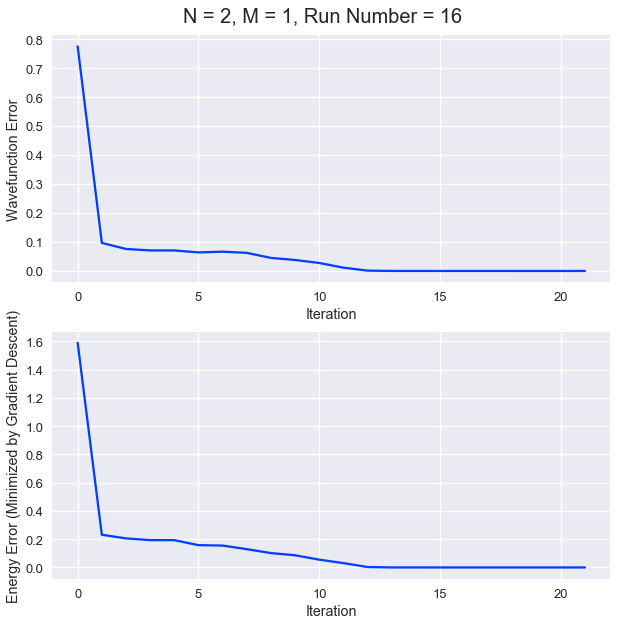

In [230]:
N=2
M=1
parResults =M1gdResults[16][0][0][5]
numIter = len(parResults)
iter = np.arange(numIter)
state = []
eng = []
stateErr = []
engErr = []


gs = M1edState[0][1] 
gsEng = ActualEng[0]

#find state at each iteration
for i in range(numIter):
    stateIter = RBM_ansatz(parResults[i],N, M)
    state.append(stateIter)
    engIter = varEnergy(parResults[i],N, M, hamiltonian(N, B, A0))
    eng.append(engIter)
    errIter = err(stateIter,gs,engIter,gsEng)
    stateErr.append(errIter[1])
    engErr.append(errIter[0])
    


plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1, Run Number = 16",size =20)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(2,1,1)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Wavefunction Error')
ax1.plot(iter, stateErr)

ax2 = plt.subplot(2,1,2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Energy Error (Minimized by Gradient Descent)')
ax2.plot(iter, engErr)

# Histogram N=2, M=2

In [90]:
#Parameter definition 
N= 2
M=2
B = 1
A0 = 1
M2gdResults = [] #gives ground state estimation at each iteration of gd
M2gdState = []
M2gdTime = []

M2edState = []
M2edTime = []

ActualEng = []
M2engErr = []
M2stateErr = []

M2hisIt = np.arange(100)

In [91]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    M2gdResults.append(gd)
    M2gdState.append(gd[0])
    M2gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    M2edState.append(ed[0])
    M2edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    ActualEng.append(edEng)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    M2engErr.append(errTemp[0])
    M2stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 18
         Function evaluations: 828
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: -0.957097
         Iterations: 79
         Function evaluations: 3042
         Gradient evaluations: 169
Optimization terminated successfully.
         Current function value: -0.957105
         Iterations: 24
         Function evaluations: 1206
         Gradient evaluations: 67
Optimization terminated successfully.
         Current function value: -0.957100
         Iterations: 55
         Function evaluations: 2484
         Gradient evaluations: 138
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 15
         Function evaluations: 450
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 20
         Function ev

Optimization terminated successfully.
         Current function value: -0.957097
         Iterations: 33
         Function evaluations: 990
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 37
         Function evaluations: 1386
         Gradient evaluations: 77
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 15
         Function evaluations: 666
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: -0.957106
         Iterations: 21
         Function evaluations: 882
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: -0.957101
         Iterations: 90
         Function evaluations: 2664
         Gradient evaluations: 148
Optimization terminated successfully.
         Current function value: -0.957104
         Iterations: 68
         Function eval

Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 15
         Function evaluations: 594
         Gradient evaluations: 33
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 14
         Function evaluations: 522
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: -0.750011
         Iterations: 4
         Function evaluations: 324
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 18
         Function evaluations: 738
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 22
         Function evaluations: 792
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 13
         Function evaluati

<Figure size 748.8x514.8 with 0 Axes>

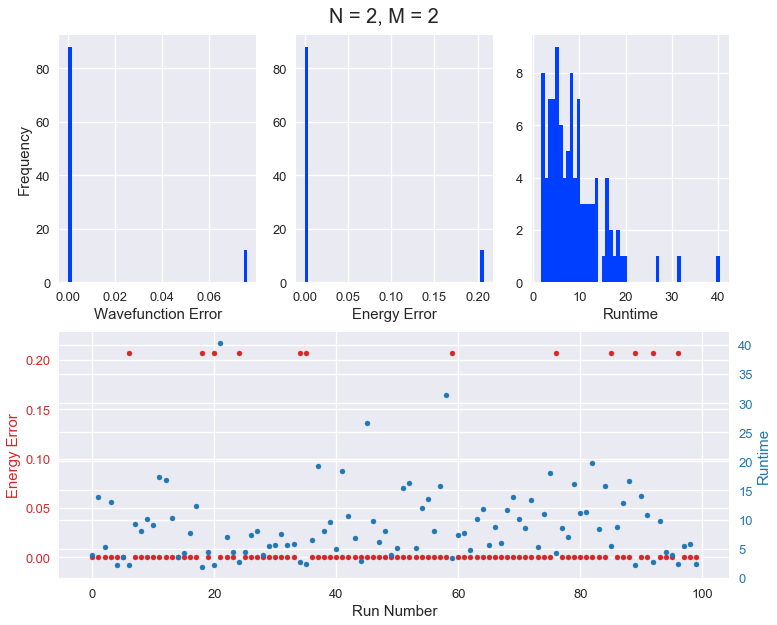

In [203]:

plt.figure(constrained_layout=True)
plt.figure(figsize=(12,10))
ttl = plt.suptitle("N = 2, M = 2",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=2)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(gs[0, 0])
ax1 .hist(M2stateErr, bins=50) 
ax1 .set_xlabel("Wavefunction Error",size = 15)
ax1 .set_ylabel("Frequency", size = 15)

ax2 = plt.subplot(gs[0, 1])
M2counts, M2bins, M2bars = ax2.hist(M2engErr, bins=50) 
ax2.set_xlabel("Energy Error",size = 15)


ax3 = plt.subplot(gs[0, 2])
ax3.hist(M2gdTime, bins=50) 
ax3.set_xlabel("Runtime",size = 15)



ax4 = plt.subplot(gs[1, :])
color = 'tab:red'
ax4.set_xlabel('Run Number',size = 15)
ax4.set_ylabel('Energy Error', color=color,size = 15)
ax4.scatter(hisIt, M2engErr,color=color, s=25)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax4.twinx()  
color = 'tab:blue'
ax5.set_ylabel('Runtime', color=color,size = 15)  
ax5.scatter(hisIt, M2gdTime, color=color, s=25)
ax5.tick_params(axis='y', labelcolor=color)



In [206]:
print(M2counts)
smallError = 0
for i in range(50):
    if M2bins[i]<0.1:
        cutOff=i
print(cutOff)

for i in range(cutOff):
    smallError += M2counts[i]
successPer = smallError
print(successPer)

[88.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 12.]
24
88.0


# Histogram N=2, M=3

In [232]:
#Parameter definition 
N= 3
M=2
B = 1
A0 = 1
M3gdResults = [] #gives ground state estimation at each iteration of gd
M3gdState = []
M3gdTime = []

M3edState = []
M3edTime = []

ActualEng = []
M3engErr = []
M3stateErr = []

M3hisIt = np.arange(100)

In [233]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    M3gdResults.append(gd)
    M3gdState.append(gd[0])
    M3gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    M3edState.append(ed[0])
    M3edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    ActualEng.append(edEng)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    M2engErr.append(errTemp[0])
    M2stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -1.280724
         Iterations: 207
         Function evaluations: 11952
         Gradient evaluations: 498
Optimization terminated successfully.
         Current function value: -1.280726
         Iterations: 88
         Function evaluations: 3624
         Gradient evaluations: 151
Optimization terminated successfully.
         Current function value: -1.280772
         Iterations: 224
         Function evaluations: 10200
         Gradient evaluations: 425
Optimization terminated successfully.
         Current function value: -1.280679
         Iterations: 82
         Function evaluations: 4800
         Gradient evaluations: 200
Optimization terminated successfully.
         Current function value: -0.999977
         Iterations: 6
         Function evaluations: 672
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: -1.280776
         Iterations: 102
         Func

KeyboardInterrupt: 

<Figure size 748.8x514.8 with 0 Axes>

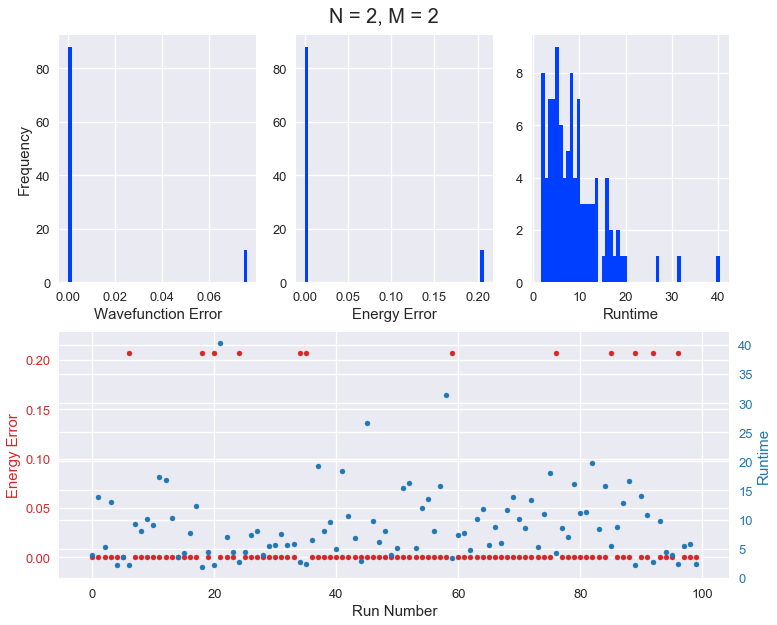

In [203]:

plt.figure(constrained_layout=True)
plt.figure(figsize=(12,10))
ttl = plt.suptitle("N = 2, M = 2",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=2)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(gs[0, 0])
ax1 .hist(M2stateErr, bins=50) 
ax1 .set_xlabel("Wavefunction Error",size = 15)
ax1 .set_ylabel("Frequency", size = 15)

ax2 = plt.subplot(gs[0, 1])
M2counts, M2bins, M2bars = ax2.hist(M2engErr, bins=50) 
ax2.set_xlabel("Energy Error",size = 15)


ax3 = plt.subplot(gs[0, 2])
ax3.hist(M2gdTime, bins=50) 
ax3.set_xlabel("Runtime",size = 15)



ax4 = plt.subplot(gs[1, :])
color = 'tab:red'
ax4.set_xlabel('Run Number',size = 15)
ax4.set_ylabel('Energy Error', color=color,size = 15)
ax4.scatter(hisIt, M2engErr,color=color, s=25)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax4.twinx()  
color = 'tab:blue'
ax5.set_ylabel('Runtime', color=color,size = 15)  
ax5.scatter(hisIt, M2gdTime, color=color, s=25)
ax5.tick_params(axis='y', labelcolor=color)



In [206]:
print(M2counts)
smallError = 0
for i in range(50):
    if M2bins[i]<0.1:
        cutOff=i
print(cutOff)

for i in range(cutOff):
    smallError += M2counts[i]
successPer = smallError
print(successPer)

[88.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 12.]
24
88.0


# Histogram N=3, M=1

In [97]:
#Parameter definition 
N= 3
M=1
B = 1
A0 = 1
N3M1gdResults = [] #gives ground state estimation at each iteration of gd
N3M1gdState = []
N3M1gdTime = []

N3M1edState = []
N3M1edTime = []

ActualEng = []
N3M1engErr = []
N3M1stateErr = []

hisIt = np.arange(100)

In [98]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    N3M1gdResults.append(gd)
    N3M1gdState.append(gd[0])
    N3M1gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    N3M1edState.append(ed[0])
    N3M1edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    ActualEng.append(edEng)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    N3M1engErr.append(errTemp[0])
    N3M1stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -1.280732
         Iterations: 190
         Function evaluations: 6880
         Gradient evaluations: 430
Optimization terminated successfully.
         Current function value: -1.280681
         Iterations: 223
         Function evaluations: 8848
         Gradient evaluations: 553
Optimization terminated successfully.
         Current function value: -0.999968
         Iterations: 7
         Function evaluations: 416
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -0.499975
         Iterations: 3
         Function evaluations: 240
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: -0.999918
         Iterations: 7
         Function evaluations: 416
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -0.999954
         Iterations: 7
         Function evalu

Optimization terminated successfully.
         Current function value: -1.280727
         Iterations: 189
         Function evaluations: 7872
         Gradient evaluations: 492
Optimization terminated successfully.
         Current function value: -1.280688
         Iterations: 156
         Function evaluations: 6288
         Gradient evaluations: 393
Optimization terminated successfully.
         Current function value: -0.999899
         Iterations: 9
         Function evaluations: 512
         Gradient evaluations: 32
Optimization terminated successfully.
         Current function value: -0.999920
         Iterations: 7
         Function evaluations: 448
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: -1.280740
         Iterations: 193
         Function evaluations: 6896
         Gradient evaluations: 431
Optimization terminated successfully.
         Current function value: -1.280726
         Iterations: 135
         Function

Optimization terminated successfully.
         Current function value: -1.280672
         Iterations: 167
         Function evaluations: 6816
         Gradient evaluations: 426
Optimization terminated successfully.
         Current function value: -0.999968
         Iterations: 8
         Function evaluations: 464
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: -0.999978
         Iterations: 4
         Function evaluations: 224
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: -1.280669
         Iterations: 207
         Function evaluations: 7872
         Gradient evaluations: 492
Optimization terminated successfully.
         Current function value: -1.280662
         Iterations: 236
         Function evaluations: 9888
         Gradient evaluations: 618
Optimization terminated successfully.
         Current function value: -1.151376
         Iterations: 151
         Function

<Figure size 748.8x514.8 with 0 Axes>

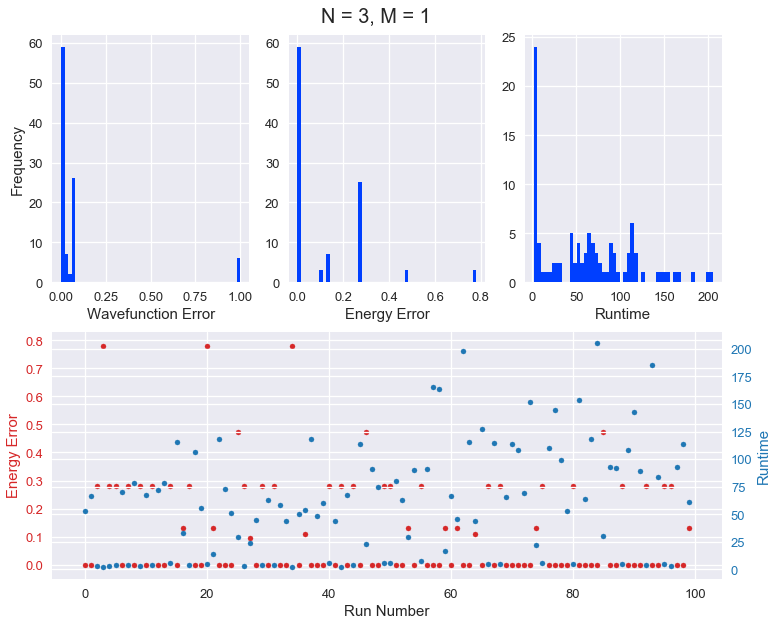

In [207]:

plt.figure(constrained_layout=True)
plt.figure(figsize=(12,10))
ttl = plt.suptitle("N = 3, M = 1",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=2)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(gs[0, 0])
ax1 .hist(N3M1stateErr, bins=50) 
ax1 .set_xlabel("Wavefunction Error",size = 15)
ax1 .set_ylabel("Frequency", size = 15)

ax2 = plt.subplot(gs[0, 1])
N3M1counts, N3M1bins, N3M1bars = ax2.hist(N3M1engErr, bins=50) 
ax2.set_xlabel("Energy Error",size = 15)


ax3 = plt.subplot(gs[0, 2])
ax3.hist(N3M1gdTime, bins=50) 
ax3.set_xlabel("Runtime",size = 15)



ax4 = plt.subplot(gs[1, :])
color = 'tab:red'
ax4.set_xlabel('Run Number',size = 15)
ax4.set_ylabel('Energy Error', color=color,size = 15)
ax4.scatter(hisIt, N3M1engErr,color=color, s=25)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax4.twinx()  
color = 'tab:blue'
ax5.set_ylabel('Runtime', color=color,size = 15)  
ax5.scatter(hisIt, N3M1gdTime, color=color, s=25)
ax5.tick_params(axis='y', labelcolor=color)



In [208]:
print(N3M1counts)
smallError = 0
for i in range(50):
    if N3M1bins[i]<0.1:
        cutOff=i
print(cutOff)

for i in range(cutOff):
    smallError += N3M1counts[i]
successPer = smallError
print(successPer)

[59.  0.  0.  0.  0.  0.  3.  0.  7.  0.  0.  0.  0.  0.  0.  0.  0. 25.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.]
6
59.0


# Histogram N=3, M=3

In [176]:
#Parameter definition 
N= 3
M=3
B = 1
A0 = 1
N3M3gdResults = [] #gives ground state estimation at each iteration of gd
N3M3gdState = []
N3M3gdTime = []

N3M3edState = []
N3M3edTime = []

ActualEng = []
N3M3engErr = []
N3M3stateErr = []

hisItShort = np.arange(100)

In [177]:
for i in range(len(hisItShort)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    N3M3gdResults.append(gd)
    N3M3gdState.append(gd[0])
    N3M3gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    N3M3edState.append(ed[0])
    N3M3edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    ActualEng.append(edEng)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    N3M3engErr.append(errTemp[0])
    N3M3stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -1.280760
         Iterations: 98
         Function evaluations: 5568
         Gradient evaluations: 174
Optimization terminated successfully.
         Current function value: -1.280771
         Iterations: 258
         Function evaluations: 16608
         Gradient evaluations: 519
Optimization terminated successfully.
         Current function value: -1.280761
         Iterations: 133
         Function evaluations: 8384
         Gradient evaluations: 262
Optimization terminated successfully.
         Current function value: -0.999989
         Iterations: 18
         Function evaluations: 1568
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: -1.280776
         Iterations: 168
         Function evaluations: 9792
         Gradient evaluations: 306
Optimization terminated successfully.
         Current function value: -1.280754
         Iterations: 122
         Fu

Optimization terminated successfully.
         Current function value: -1.280759
         Iterations: 146
         Function evaluations: 10208
         Gradient evaluations: 319
Optimization terminated successfully.
         Current function value: -0.499989
         Iterations: 7
         Function evaluations: 928
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: -1.280749
         Iterations: 125
         Function evaluations: 8544
         Gradient evaluations: 267
Optimization terminated successfully.
         Current function value: -0.999987
         Iterations: 3
         Function evaluations: 288
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: -0.999982
         Iterations: 7
         Function evaluations: 832
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -0.999984
         Iterations: 8
         Function evalu

Optimization terminated successfully.
         Current function value: -0.999975
         Iterations: 6
         Function evaluations: 768
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: -1.151374
         Iterations: 63
         Function evaluations: 4064
         Gradient evaluations: 127
Optimization terminated successfully.
         Current function value: -1.280745
         Iterations: 242
         Function evaluations: 16672
         Gradient evaluations: 521
Optimization terminated successfully.
         Current function value: -1.280774
         Iterations: 110
         Function evaluations: 6784
         Gradient evaluations: 212
Optimization terminated successfully.
         Current function value: -1.280717
         Iterations: 119
         Function evaluations: 7808
         Gradient evaluations: 244
Optimization terminated successfully.
         Current function value: -1.280734
         Iterations: 382
         Func

<Figure size 748.8x514.8 with 0 Axes>

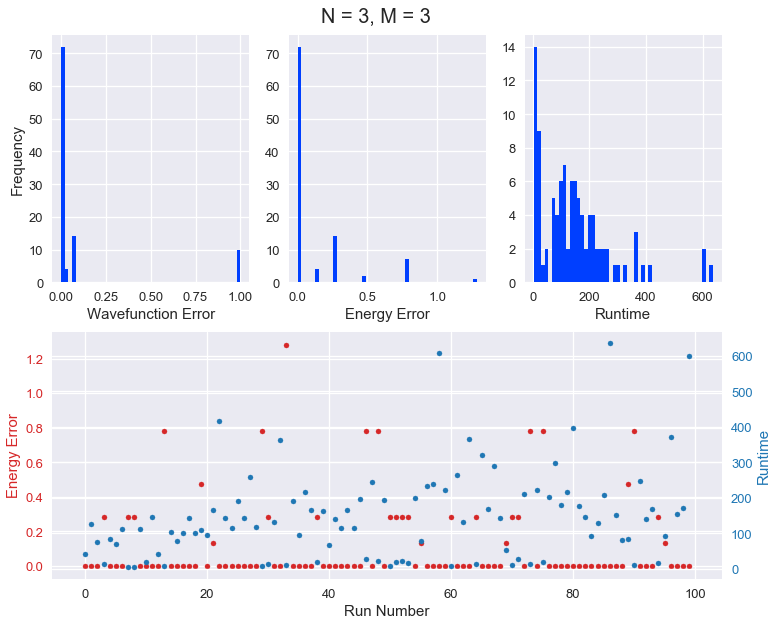

In [209]:
plt.figure(constrained_layout=True)
plt.figure(figsize=(12,10))
ttl = plt.suptitle("N = 3, M = 3",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=2)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(gs[0, 0])
ax1 .hist(N3M3stateErr, bins=50) 
ax1 .set_xlabel("Wavefunction Error",size = 15)
ax1 .set_ylabel("Frequency", size = 15)

ax2 = plt.subplot(gs[0, 1])
N3M3counts, N3M3bins, N3M3bars = ax2.hist(N3M3engErr, bins=50) 
ax2.set_xlabel("Energy Error",size = 15)


ax3 = plt.subplot(gs[0, 2])
ax3.hist(N3M3gdTime, bins=50) 
ax3.set_xlabel("Runtime",size = 15)



ax4 = plt.subplot(gs[1, :])
color = 'tab:red'
ax4.set_xlabel('Run Number',size = 15)
ax4.set_ylabel('Energy Error', color=color,size = 15)
ax4.scatter(hisItShort, N3M3engErr,color=color, s=25)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax4.twinx()  
color = 'tab:blue'
ax5.set_ylabel('Runtime', color=color,size = 15)  
ax5.scatter(hisItShort, N3M3gdTime, color=color, s=25)
ax5.tick_params(axis='y', labelcolor=color)





In [211]:
print(N3M3counts)
smallError = 0
for i in range(50):
    if N3M3bins[i]<0.1:
        cutOff=i
print(cutOff)

for i in range(cutOff):
    smallError += N3M3counts[i]
successPer = smallError
print(successPer)

[72.  0.  0.  0.  0.  4.  0.  0.  0.  0. 14.  0.  0.  0.  0.  0.  0.  0.
  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  7.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
3
72.0
